# <a id='toc1_'></a>[Realtime Example Notebook w/ OpenBCI Cyton Board](#toc0_)

This notebook demonstrates how to get started with python & the openBCI cyton board. We will use the brainflow library as a backend to interface with the board and acquire data, however I have created a custom module to make it easier to use brainflow with the cyton board. This notebook will show you how to set up the board, start a stream, and visualize the data in real-time.

**NOTE:** If you want to use the custom module, you will need to have the file `brainflow_stream.py` in the same directory as this notebook (or other scripts that use it).

**Table of contents**<a id='toc0_'></a>    
- [Realtime Example Notebook w/ OpenBCI Cyton Board](#toc1_)    
  - [Installation](#toc1_1_)    
- [Connecting to the cyton board](#toc2_)    
  - [Create a BrainFlowBoard object](#toc2_1_)    
      - [Parameters](#toc2_1_1_1_)    
  - [Get Data](#toc2_2_)    
- [Basic data processing (DC offset)](#toc3_)    
- [Event Markers](#toc4_)    
- [Classification Basics](#toc5_)    
  - [Bandpowers](#toc5_1_)    
  - [CCA Classification](#toc5_2_)    
- [BONUS: Converting cyton data to an MNE object](#toc6_)    
- [Resources](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Installation](#toc0_)

Make sure you have the provided `neurohack` python environment installed.

Or you can install the following packages:

```bash
conda/pip install brainflow scipy matplotlib pyserial jupyterlab
```

In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import time

import brainflow
from brainflow.board_shim import BoardShim, BrainFlowInputParams, BrainFlowError, BoardIds


# Import the custom module.
from brainflow_stream import BrainFlowBoardSetup

c:\Users\surge\miniforge3\envs\Brainhack\Lib\site-packages\brainflow\board_shim.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# <a id='toc2_'></a>[Connecting to the cyton board](#toc0_)

## <a id='toc2_1_'></a>[Create a BrainFlowBoard object](#toc0_)

The `BrainFlowBoardSetup()` object is a custom wrapper to the Brainflow BoardShim object. There is some added utility to the custom wrapper, such as the ability to automatically detect the serial port of the Cyton board.

For specifics on the custom class, expand below or see the `brainflow_stream.py` module for more details.

<details>
<summary>Expand for more details on the `BrainFlowBoardSetup()` object</summary>

#### <a id='toc2_1_1_1_'></a>[Parameters](#toc0_)
- **board_id** (*int*): ID of the BrainFlow board.
- **name** (*str*, optional): User-friendly identifier (useful when connecting to multiple boards).
- **serial_port** (*str*, optinoal): Serial port for the BrainFlow board.
- **master_board** (*int*, optional): ID of the master board (playback/synthetic only).
- **params** (*BrainFlowInputParams*, optional): Input parameters for the board.

</details>

In [2]:
board_id = BoardIds.CYTON_BOARD.value # Set the board_id to match the Cyton board

# Lets quickly take a look at the specifications of the Cyton board
for item1, item2 in BoardShim.get_board_descr(board_id).items():
    print(f"{item1}: {item2}")

accel_channels: [9, 10, 11]
analog_channels: [19, 20, 21]
ecg_channels: [1, 2, 3, 4, 5, 6, 7, 8]
eeg_channels: [1, 2, 3, 4, 5, 6, 7, 8]
eeg_names: Fp1,Fp2,C3,C4,P7,P8,O1,O2
emg_channels: [1, 2, 3, 4, 5, 6, 7, 8]
eog_channels: [1, 2, 3, 4, 5, 6, 7, 8]
marker_channel: 23
name: Cyton
num_rows: 24
other_channels: [12, 13, 14, 15, 16, 17, 18]
package_num_channel: 0
sampling_rate: 250
timestamp_channel: 22


In [3]:
cyton_board = BrainFlowBoardSetup(
                                board_id = board_id,
                                name = 'Board_1',   # Optional name for the board. This is useful if you have multiple boards connected and want to distinguish between them.
                                serial_port = None  # If the serial port is not specified, it will try to auto-detect the board. If this fails, you will have to assign the correct serial port. See https://docs.openbci.com/GettingStarted/Boards/CytonGS/ 
                                ) 

cyton_board.setup() # This will establish a connection to the board and start streaming data.

No serial port provided, attempting to auto-detect...
Compatible device found: Serial Number: DM01HZK9A, Description: USB Serial Port (COM5)
[Board_1, COM5] Board setup and streaming started successfully.


Once the board is connected and streaming, we can call some utility functions to get some information about the board.

In [4]:
board_info = cyton_board.get_board_info() # Retrieves the EEG channel and sampling rate of the board.
print(f"Board info: {board_info}")

board_srate = cyton_board.get_sampling_rate() # Retrieves the sampling rate of the board.
print(f"Board sampling rate: {board_srate}")

Board info: ([1, 2, 3, 4, 5, 6, 7, 8], 250)
Board sampling rate: 250


We can also look at the specifications of the board.

## <a id='toc2_2_'></a>[Get Data](#toc0_)

Once connected, the board starts streaming data into the computers' buffer where it is stored temporarily. The default buffer size is 450000 (at 250Hz sampling rate, this is 30 minutes). We can then pull data from the buffer and process it.

There are **Two ways** to pull data from the board/buffer.
1. `get_board_data()` -> Retrieves and clears ALL samples from the buffer. 
2. `get_current_board_data(num_samples)` -> Retrieves the last `num_samples` samples without clearing them from the buffer.

For more information on the buffer and behind-the-scenes see the [brainflow documentation](https://brainflow.readthedocs.io/en/stable/UserAPI.html#brainflow-board-shim).

In [5]:
time.sleep(5) # Wait for 5 seconds to allow the board to build up some samples into the buffer

raw_data_500 = cyton_board.get_current_board_data(num_samples = 500) # Get the latest 500 samples from the buffer
print(f"raw_data_1000 shape: {raw_data_500.shape}")

raw_data_all = cyton_board.get_board_data() 
print(f"raw_data_all shape: {raw_data_all.shape}")

raw_data_1000 shape: (24, 500)
raw_data_all shape: (24, 1203)


As we can see here, each method returns a tuple of two arrays in shape **(n_channels, n_samples)**

Since the cyton_board only has 8 eeg channels, the other channels contain data on other sensors like the accelerometer, gyroscope, etc.

For the Cyton boards this is the channel mapping:
- {'accel_channels': [9, 10, 11], 
- 'analog_channels': [19, 20, 21], 
- 'eeg_channels': [1, 2, 3, 4, 5, 6, 7, 8], 
- 'eeg_names': 'Fp1,Fp2,C3,C4,P7,P8,O1,O2', 
- 'marker_channel': 23, 
- 'other_channels': [12, 13, 14, 15, 16, 17, 18], 
- 'package_num_channel': 0, 
- 'sampling_rate': 250, 
- 'timestamp_channel': 22}

So, lets slice out only the EEG channels from our raw data

In [6]:
eeg_data = raw_data_500[1:9, :] # Get the EEG data from the first 8 channels
print(f"eeg_data shape: {eeg_data.shape}")

eeg_data shape: (8, 500)


Great, now lets visualize the data using matplotlib

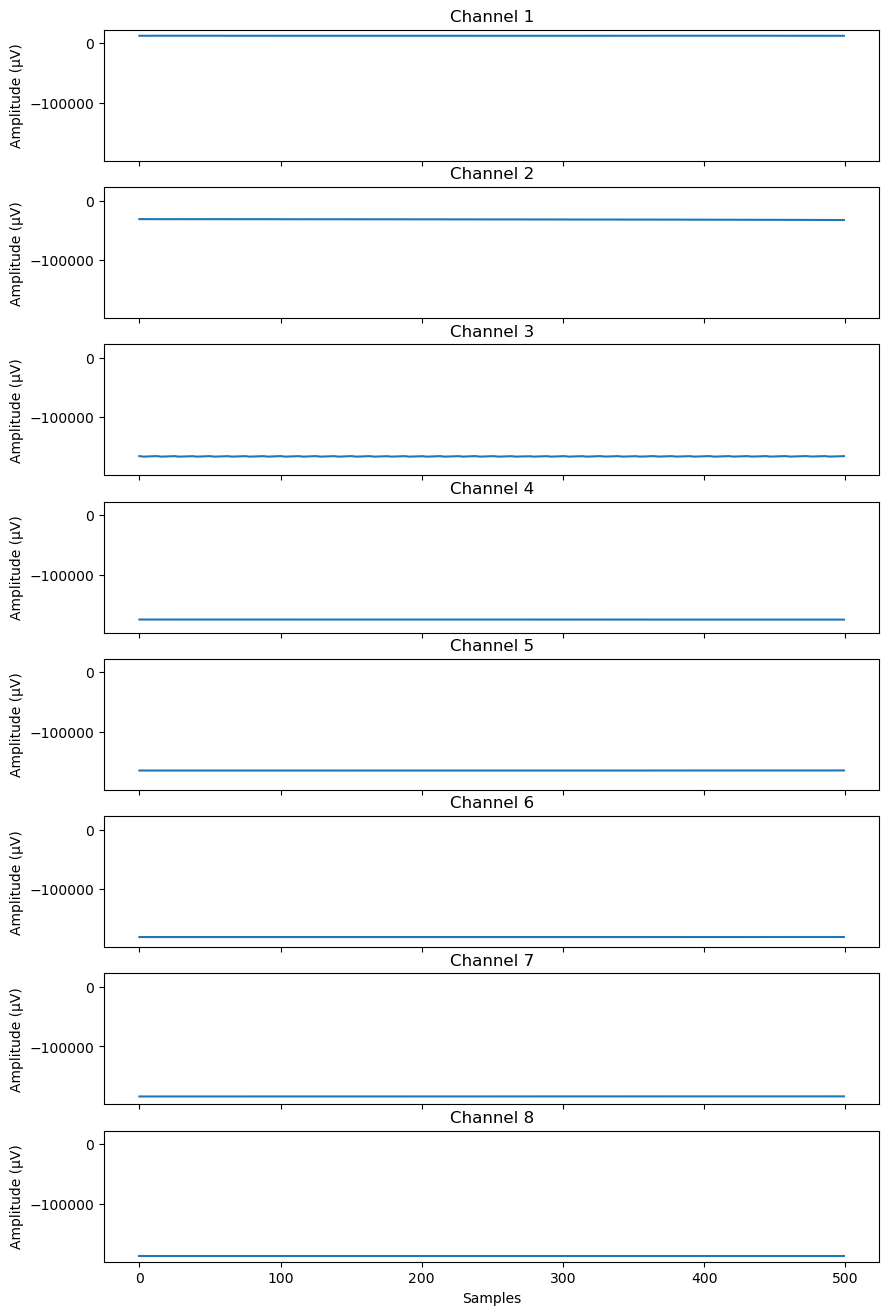

In [7]:
num_channels = eeg_data.shape[0]
num_samples = eeg_data.shape[1]

# Create a figure and a set of subplots
fig, axes = plt.subplots(num_channels, 1, figsize=(10, 2 * num_channels), sharex=True, sharey=True)

# Plot each channel
for i in range(num_channels):
    axes[i].plot(eeg_data[i, :])
    axes[i].set_title(f'Channel {i+1}')
    axes[i].set_ylabel('Amplitude (µV)')

axes[-1].set_xlabel('Samples')

plt.show()

# <a id='toc3_'></a>[Basic data processing (DC offset)](#toc0_)

If you look at the above graph of the raw data, the X-axis looks off - those values are far too large! Let's normalize the data so that it's centered around 0. 

In [8]:
# To do this we can subtract the mean of the data from the data itself. This will center the data around zero.
eeg_data_dc_removed = eeg_data - np.mean(eeg_data, axis=1, keepdims=True)

# While we're at it, lets make a small function that performs all of our minimal processing this since we'll have to do it every time we pull data from the board.
def remove_dc_offset(data):
    return data[1:9, :] - np.mean(data[1:9, :], axis=1, keepdims=True)

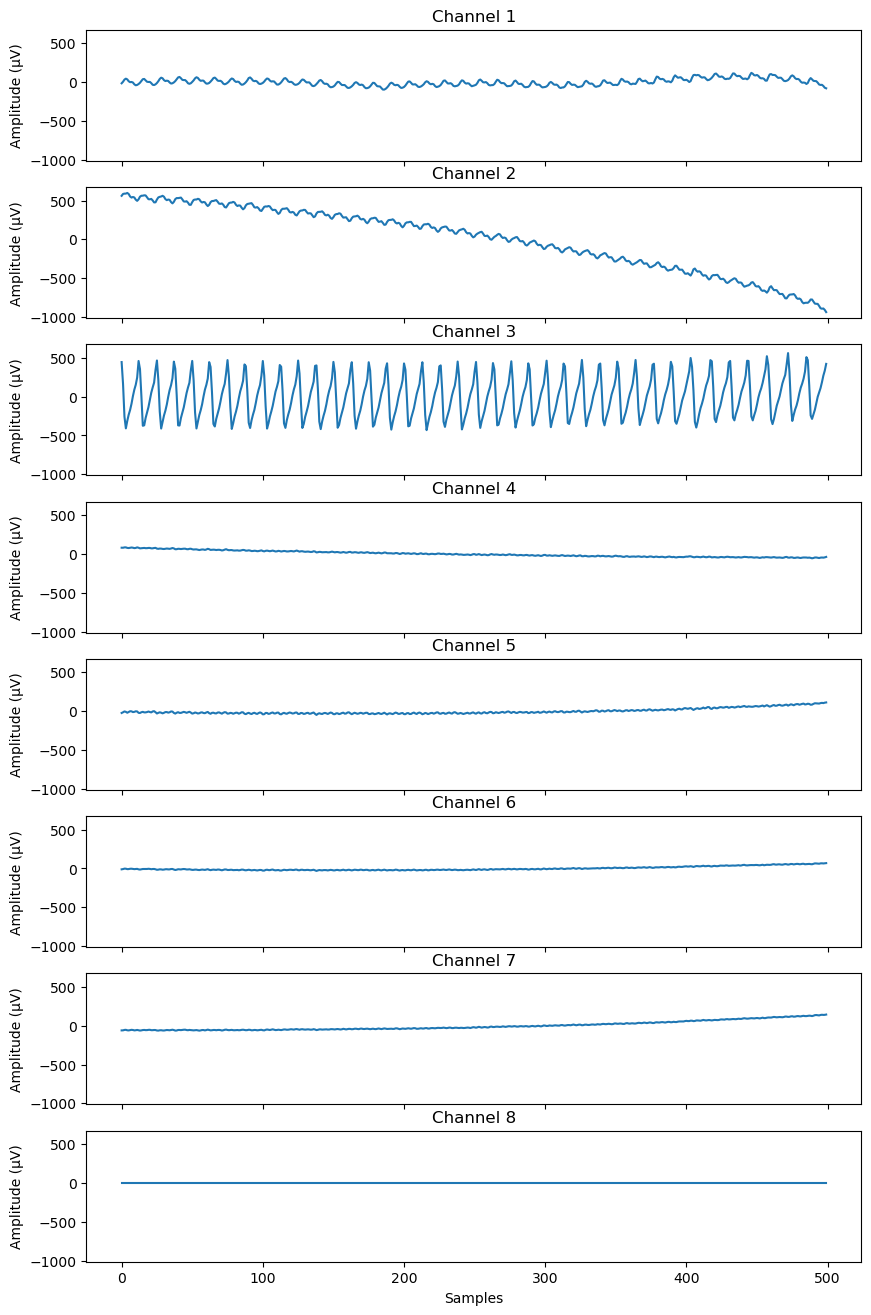

In [9]:
# Now let's plot the results
num_channels = eeg_data_dc_removed.shape[0]
num_samples = eeg_data_dc_removed.shape[1]

fig, axes = plt.subplots(num_channels, 1, figsize=(10, 2 * num_channels), sharex=True, sharey=True)

for i in range(num_channels):
    axes[i].plot(eeg_data_dc_removed[i, :])
    axes[i].set_title(f'Channel {i+1}')
    axes[i].set_ylabel('Amplitude (µV)')

axes[-1].set_xlabel('Samples')

plt.show()

That looks much better!

# <a id='toc4_'></a>[Event Markers](#toc0_)

Event markers are essential in BCI systems because they indicate specific times in the EEG stream when an event occurs, such as a stimulus presentation or a button press. These markers make it possible to segment the data into epochs, or windows of EEG activity, centered around the event. Since the goal of classification is to separate meaningful brain responses from noise, event markers provide the foundation for extracting relevant EEG segments and training classifiers to distinguish between event-related activity and background or irrelevant signals.

We can add markers to the data stream by calling `insert_marker()`. The marker itself has to be a number, and will have to be decoded later on. (i.e., what does the marker number 5 mean?)

Lets make a small loop which inserts a marker every 0.5 seconds for 5 seconds.

In [10]:
for _ in range(10):  # 5 seconds / 0.5 seconds = 10 iterations
    cyton_board.insert_marker(marker=10,
                                verbose=True # You can set this to False if you don't want to print the marker value
                                )
    time.sleep(0.5)
    
# Then, lets pull the last 5 seconds of data (250 samples per second * 5 seconds = 1250 samples)
raw_data_1250 = cyton_board.get_current_board_data(num_samples = 1250)

[Board_1] Marker 10 inserted successfully.
[Board_1] Marker 10 inserted successfully.
[Board_1] Marker 10 inserted successfully.
[Board_1] Marker 10 inserted successfully.
[Board_1] Marker 10 inserted successfully.
[Board_1] Marker 10 inserted successfully.
[Board_1] Marker 10 inserted successfully.
[Board_1] Marker 10 inserted successfully.
[Board_1] Marker 10 inserted successfully.
[Board_1] Marker 10 inserted successfully.


Now, lets do our minimal processing by taking out the marker channel, and then the EEG channels normalizing the raw data.

In [11]:
# Extract marker channel (assuming it's at index 23)
marker_data = raw_data_1250[23, :]  # Single row, all time points

# Lets use the function we made earlier to extract eeg channels and normalize the data!
eeg_data_dc_offset_removed = remove_dc_offset(eeg_data)

Now, lets visualize the EEG data, with a vertical line for each marker.

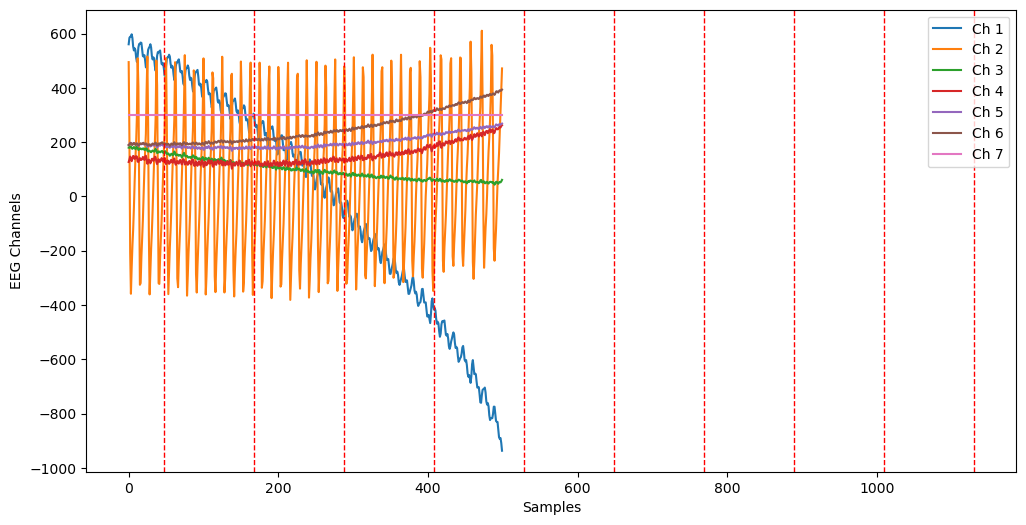

In [12]:
# Get number of samples
num_samples = eeg_data_dc_offset_removed.shape[1]

# Find marker event indices
event_indices = np.where(marker_data == 10)[0] # Find the samples where the marker is 10

# Plot EEG data with markers
plt.figure(figsize=(12, 6))
offset = 50  # Spacing between channels for easier visualization

for i in range(eeg_data_dc_offset_removed.shape[0]):
    plt.plot(eeg_data_dc_offset_removed[i] + i * offset, label=f'Ch {i+1}')

# Add vertical lines for markers
for event in event_indices:
    plt.axvline(event, color='r', linestyle='--', linewidth=1)

plt.xlabel("Samples")
plt.ylabel("EEG Channels")
plt.legend(loc="upper right")
plt.show()

# <a id='toc5_'></a>[Classification Basics](#toc0_)
In this section, I will demonstrate some basic ways to classify EEG data using the data we acquired from the Cyton board. 
The examples provided below are very basic and could be improved upon, but feel free to use them and/or improve upon them as you see fit!

## <a id='toc5_1_'></a>[Bandpowers](#toc0_)
Here I will provide an example function to compute bandpowers of the EEG data. This is a very basic implementation and can be improved upon. 
Band powers are a common feature used in EEG analysis and BCI systems. They represent the power of the EEG signal in specific frequency bands. The most common frequency bands are:
- Delta: 0.5 - 4 Hz
- Theta: 4 - 8 Hz
- Alpha: 8 - 13 Hz
- Beta: 13 - 30 Hz
- Gamma: 30 - 100 Hz

Using bandpowers - and sometimes ratios of bandpowers (e.g., alpha:beta) - can be useful features for classification.

In [13]:
from scipy.signal import welch

def compute_band_powers(eeg_data, sfreq, bands=None, nperseg=1024):
    """
    Compute band powers from EEG data using Welch's method.

    Parameters
    ----------
    eeg_data : ndarray
        EEG signal, shape (n_channels, n_samples).
    sfreq : float
        Sampling frequency in Hz.
    bands : dict, optional
        Frequency bands as {"band": (low, high)} in Hz.
        Defaults to standard EEG bands.
    nperseg : int, optional
        Length of each segment for Welch PSD.

    Returns
    -------
    band_powers : dict
        Dictionary with keys = band names, values = array of shape (n_channels,)
        containing average band power for each channel.
    """
    if bands is None:
        bands = {
            "delta": (1, 4),
            "theta": (4, 8),
            "alpha": (8, 12),
            "beta": (12, 30),
            "gamma": (30, 100),
        }

    n_channels = eeg_data.shape[0]
    band_powers = {band: np.zeros(n_channels) for band in bands}

    # Compute PSD per channel
    for ch in range(n_channels):
        freqs, psd = welch(eeg_data[ch], sfreq, nperseg=nperseg)

        for band, (low, high) in bands.items():
            idx = np.logical_and(freqs >= low, freqs <= high)
            band_powers[band][ch] = np.trapezoid(psd[idx], freqs[idx])  # integrate power

    return band_powers



# --- Example Usage: ---
sfreq = cyton_board.get_sampling_rate()

eeg_data = remove_dc_offset(cyton_board.get_current_board_data(num_samples=500))

band_powers = compute_band_powers(eeg_data, sfreq)

print("Band Powers:")
for band, powers in band_powers.items():
    print(f"{band}: {powers}")
    # You can add further processing or visualization of the band powers here


Band Powers:
delta: [1263.44418108  259.18459531   28.59508029    7.89315081   14.19551078
    7.54702115   22.82199784    0.        ]
theta: [ 6.74529484  4.06293968 13.25183847  0.57931869  1.17323189  0.53960009
  0.61133512  0.        ]
alpha: [ 1.71877634  1.43097534 50.68202174  0.38692794  1.56046064  0.46223409
  0.47894367  0.        ]
beta: [6.04711588e+02 5.73897944e+02 6.40209073e+04 2.65075311e+00
 6.43709633e+00 1.28527332e+00 9.58949662e-01 0.00000000e+00]
gamma: [9.12595602e+01 1.14190581e+02 7.67559406e+03 7.46471982e+00
 2.29503688e+01 5.67883837e+00 6.04873963e+00 0.00000000e+00]


C:\Users\surge\AppData\Local\Temp\ipykernel_17388\984797987.py:39: UserWarning: nperseg=1024 is greater than signal length max(len(x), len(y)) = 500, using nperseg = 500
  freqs, psd = welch(eeg_data[ch], sfreq, nperseg=nperseg)


## <a id='toc5_2_'></a>[CCA Classification](#toc0_)
Canonical Correlation Analysis (CCA) is a statistical method used to understand the relationships between two sets of variables. In the context of EEG and BCI, CCA can be employed to identify patterns in EEG data that correspond to specific stimuli or tasks. More specifically, CCA can be used to classify EEG that are maximally correlated with reference signals, which can be particularly useful in scenarios like **SSVEP-based BCIs.**

In practice, how this would work is you give the CCA algorithm two sets of data:
   1. The EEG data (X)
   2. The reference signals (Y) - these are typically sine and cosine waves at the frequencies of interest (i.e., the frequencies of the visual stimuli in an SSVEP BCI).

The CCA algorithm then finds linear combinations of the EEG data and the reference signals that are maximally correlated. The resulting canonical variates can then be used as features for classification.

In the code cell below, I have supplied a basic implementation of CCA classification. This implementation requires minimally processed EEG data, and a list of frequencies of interest. The function will return the correlation scores for each frequency, which can be used to determine which frequency the EEG data is most correlated with.

As a final note - SSVEP signals are maximally present in the occipital region of the brain (the back of the head). Therefore, it is common practice to use only the occipital EEG channels for SSVEP classification. In this example, I have not implemented any channel selection, but it is something to consider when using CCA for SSVEP classification.

In [14]:
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler

def basic_cca(eeg_data, sfreq, freqs):
    """
    Very basic CCA for EEG SSVEP analysis with 2 harmonics.

    Parameters
    ----------
    eeg_data : ndarray, shape (n_channels, n_samples)
        EEG segment aligned to stimulus.
    sfreq : float
        Sampling frequency (Hz).
    freqs : list of float
        Frequencies of interest in Hz.

    Returns
    -------
    scores : dict
        {frequency: first canonical correlation}
    """
    n_channels, n_samples = eeg_data.shape
    t = np.arange(n_samples) / sfreq
    X = eeg_data.T                     # shape (n_samples, n_channels)
    Xs = StandardScaler().fit_transform(X)

    scores = {}
    for f in freqs:
        # Reference signals: sine/cosine at f and 2f
        ref = np.column_stack([
            np.sin(2*np.pi*f*t),
            np.cos(2*np.pi*f*t),
            np.sin(2*np.pi*2*f*t),
            np.cos(2*np.pi*2*f*t)
        ])
        Rs = StandardScaler().fit_transform(ref)

        cca = CCA(n_components=1)
        U, V = cca.fit_transform(Xs, Rs)
        corr = np.corrcoef(U[:, 0], V[:, 0])[0, 1]
        scores[f] = float(corr)

    return scores



# --- Example Usage: ---
sfreq = cyton_board.get_sampling_rate()
eeg_data = remove_dc_offset(cyton_board.get_current_board_data(num_samples=500))
freqs_of_interest = [8, 10, 12]  # Example frequencies in Hz

cca_scores = basic_cca(eeg_data, sfreq, freqs_of_interest)

print("CCA Scores:")
for f, score in cca_scores.items():
    print(f"{f} Hz: {score}")
    # You can add further processing or visualization of the CCA scores here


CCA Scores:
8 Hz: 0.15999174436999813
10 Hz: 0.09646312196783532
12 Hz: 0.261875190176313


# <a id='toc6_'></a>[BONUS: Converting cyton data to an MNE object](#toc0_)
**[MNE Python](https://mne.tools/stable/index.html)** is a powerful python library for EEG data analysis. It has a lot of built-in functions for data processing, visualization, and analysis.

In this section I will quickly demonstrate how you can take the raw data from the Cyton board and convert it into an MNE Raw object, which can then be used with all the MNE functions.

In [15]:
# First, lets take a large amount (30 seconds) to make the conversion worthwhile

time.sleep(30) # We have to wait for the buffer to fill up with data before we can pull it.

raw_data_7500 = cyton_board.get_current_board_data(num_samples = 7500)

# Then lets perform our minimal processing on the data normalize the data
eeg_data_cleaned = remove_dc_offset(raw_data_7500)

In [16]:
# Then lets perform our minimal processing on the data normalize the data
eeg_data_cleaned = remove_dc_offset(raw_data_7500)

In [17]:
import mne

# Get channel names -> Can also define them manually
ch_names = cyton_board.get_eeg_names(board_id)

# Define channel types (MNE needs this)
ch_types = ['eeg'] * len(ch_names)

sampling_rate = cyton_board.get_sampling_rate()

# Create MNE info structure
info = mne.create_info(ch_names=ch_names, sfreq=sampling_rate, ch_types=ch_types)


In [18]:
# For MNE to work properly, we need to convert the data to Volts
eeg_data_cleaned = eeg_data_cleaned * 1e-6 # Multiply the EEG data by 1e-6 to convert to Volts

# Create the RawArray object
raw = mne.io.RawArray(eeg_data_cleaned, info)

# Plot to verify
raw.plot()

Creating RawArray with float64 data, n_channels=8, n_times=7500
    Range : 0 ... 7499 =      0.000 ...    29.996 secs
Ready.
Using qt as 2D backend.


c:\Users\surge\miniforge3\envs\Brainhack\Lib\site-packages\mne_qt_browser\_pg_figure.py:4903: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z = zscore(data, axis=1)


Finally, lets stop streaming from the board.

In [19]:
cyton_board.stop()

[Board_1, COM5] Streaming stopped.
[Board_1, COM5] Session released.


# <a id='toc7_'></a>[Resources](#toc0_)

- [Brainflow Python Documentation](https://brainflow.readthedocs.io/en/stable/Examples.html#python)
- [MNE Python](https://mne.tools/stable/index.html)